In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wave, struct, math, random
from sklearn.linear_model import LinearRegression
from scipy import signal
from scipy import stats
from nptdms import TdmsFile

import scipy

from scipy.signal import find_peaks, peak_prominences
from collections import Counter
import os
import json
import re
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
import fnmatch
import os
from glob import glob
from array import array
# first part with least squares
from scipy.optimize import curve_fit
 
# second part about ODR
from scipy.odr import ODR, Model, Data, RealData
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#!pip install plotly==5.11.0
import plotly.express as px
import plotly.graph_objects as go

In [85]:
def loadMonitors(monitorFiles):
    dts=[]
    t0=-1
    CVMonitor=[]
    for monitor in monitorFiles:
        tdms_file = TdmsFile.read(monitor)
        timeC=[]
        current=[]
        for group in tdms_file.groups():
            group_name = group.name
            for channel in group.channels():
                channel_name = channel.name
                if (channel_name=="Time"):
                    timeC=np.array(channel) 
                elif channel_name=="Bias":
                    bias=channel
                else:    
                    current=np.array(channel) 

        if t0==-1:
            t0=timeC[0]
        timeC=timeC-t0
        if len(timeC)>110:
            dt_m=np.mean(np.abs(np.diff(timeC)))
            if np.isnan(dt_m)==False:
                dts.append(dt_m)
            CVMonitor.append([timeC[50:] ,current[50:] /-.2])    
       
     
    return CVMonitor,t0,np.mean(dts)




def loadMI(filename):
    size=os.path.getsize(filename)
    current=[]
    
    distance=[]
    times=[]
    data = array('B')
    with open(filename, "rb") as file1:
        # Reading form a file
        d=file1.readline()
        chunks=[]
        while d!='data          BINARY\n':
            d=file1.readline().decode('ascii')
            dd=d.strip().split(' ')
            if  dd[0]==('bias'):
                bias =float(dd[-1]) 
            if  d.startswith('chunk'):
                parts = d.split('\t')
                dist=float(parts[5])
                time=float(parts[3])
                chunks.append({'points':int(parts[1]),'distperpoint':dist, 'timeperpoint':time})

        loc = file1.tell()
        binarySize =size-loc
        data.fromfile(file1,binarySize )
        i=0
        cDist=0
        for chunk in chunks:
            chunkDist=[]
            chunkCurrent=[]
            for j in range(0,chunk['points']):
                f=(struct.unpack('<f', data[i:i+4]))
                chunkCurrent.append(f)
                cDist+=chunk['distperpoint']
                chunkDist.append(cDist)
                i+=4
                
           
            distance.append(np.array(chunkDist)*1e9)
            current.append(np.array(chunkCurrent).ravel())
            times.append(  np.linspace(0, len(chunkDist)*chunk['timeperpoint'], len(chunkDist)))
    return distance,current,bias,times


def loadTDMSCurve(dataFile):
    tdms_file = TdmsFile.read(file)
    for group in tdms_file.groups():
        group_name = group.name
        bias=[]
        for channel in group.channels():
            channel_name = channel.name
            if (channel_name=="Time"):
                timeC1=np.array(channel) 
                timeC1=np.linspace(timeC1[0],timeC1[-1],len(timeC1))
            elif channel_name=="Bias":
                bias=np.array(channel)
            else:    
                currentIV=np.array(channel)
    return timeC1,currentIV,bias  

def CutTDMS(times,currents,bias,maxTime):
    t=times
    cond=np.abs(currents/bias)
    cutoff=np.abs(10/np.mean(bias))*.99
    uppers=np.argwhere(cond>cutoff).ravel()
    if len(uppers)==0:
        return []
    diffs=np.diff(uppers)
    starts=np.argwhere(diffs!=1).ravel()

    cuts=[]
    if len(starts)==0:
            t2=t[uppers[-1]:]
            c2=cond[uppers[-1]:]
            t2=t2[c2<cutoff]
            c2=c2[c2<cutoff]

            t3=t[:uppers[0]]*-1
            c3=cond[:uppers[0]]
            t3=t3[c3<cutoff]
            c3=c3[c3<cutoff]
            if len(t2)>500:
                t2=(t2-t2[0])
                c2=c2[t2<maxTime]
                t2=t2[t2<maxTime]
                #plt.semilogy(t2  ,c2)
                #plt.show()
                cuts.append({'times':t2  ,'conductance':c2})

    else:    
        for i in range(1,len(starts)-1):
            t2=t[uppers[starts[i]]:uppers[starts[i+1]]]
            c2=cond[uppers[starts[i]]:uppers[starts[i+1]]]
            t2=t2[c2<cutoff]
            c2=c2[c2<cutoff]
            if len(t2)>500:
                t2=(t2-t2[0])
                c2=c2[t2<maxTime]
                t2=t2[t2<maxTime]
                #plt.semilogy(t2 ,c2)
                #plt.show()
                cuts.append({'times':t2   ,'conductance':c2})    
    return cuts

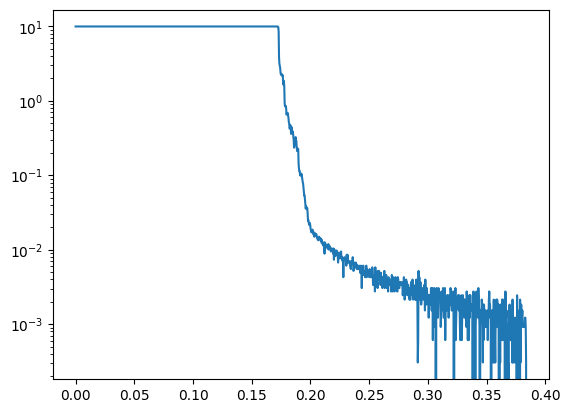

In [92]:
sDir=r"S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\STM\DNA\20230131_STMBJ_dsDNA Cit\dsDNA18_Cit_2\*.mi"
dataFiles = glob( sDir, recursive=False)
curves=[]
for file in dataFiles[:10]:
    distance,currents,bias,times=loadMI(file)
    plt.semilogy(times[0],-1* currents[0])
    break

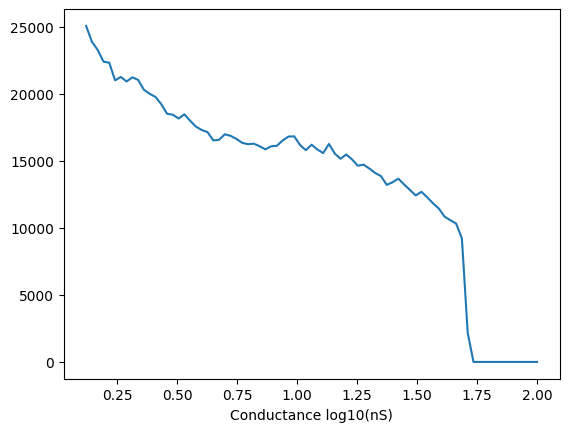

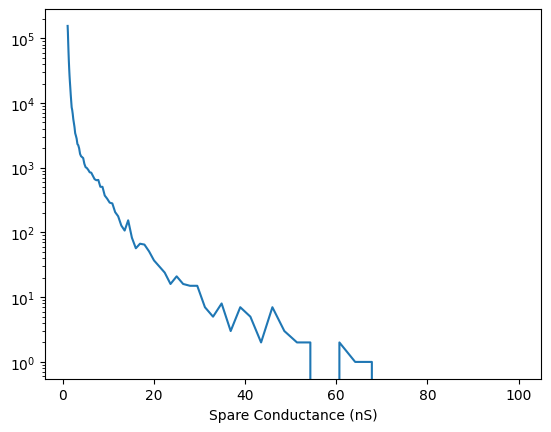

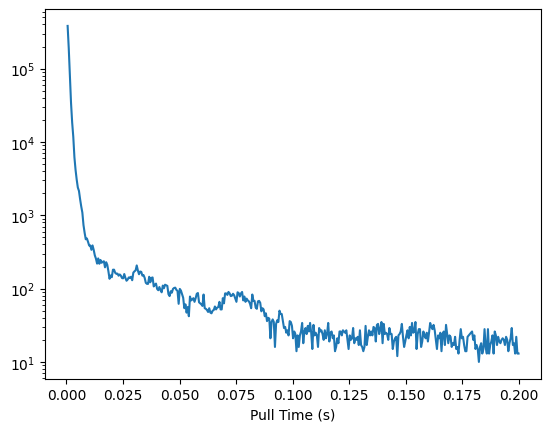

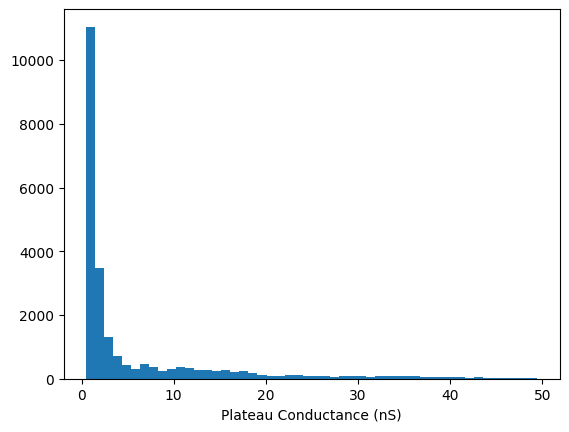

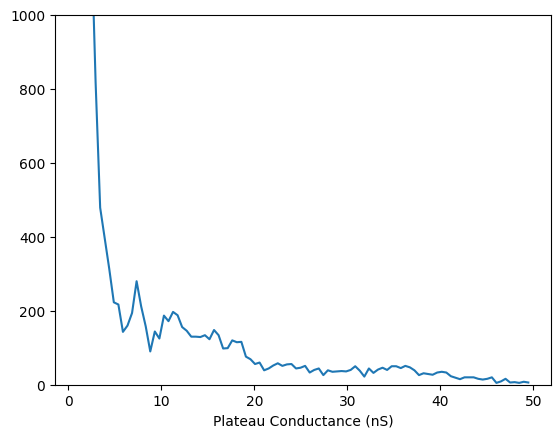

In [167]:
sDir=r"S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\STM\DNA\20230131_STMBJ_dsDNA Cit\dsDNA18_Cit_2\*.tdms"
dataFiles = glob( sDir, recursive=False)
curves=[]
bins=np.linspace(-4,2,250)
values=np.zeros(len(bins)-1)
values2=np.zeros(len(bins)-1)

bins_dist=np.linspace(0,.2,400)
values_dist=np.zeros(len(bins_dist)-1)
slopes=[]
sigCond=[]
for file in dataFiles:
    times,currents,bias=loadTDMSCurve(file)
    #plt.plot(times-times[0],np.abs(currents))
    #plt.show()
    
    cuts=CutTDMS(times,currents,bias,.1)
    for cut in cuts:
        lcond=cut['conductance']
        ltime=cut['times'][lcond>.5]
        lcond=np.log10(lcond[lcond>.5])
        
        if len(lcond)>2:
            p=np.polyfit(ltime,lcond,1)
            slopes.append(p[0])
            #plt.plot(ltime,lcond)
            #plt.plot(ltime,p[0]*ltime+p[1])

            if p[0]<-200:
                minSlope=-200
            else:
                minSlope=p[0]

            v,_=np.histogram(np.log10(cut['conductance']),bins=bins)
            values+=v

            error = lcond-(minSlope*ltime+p[1])
            v,_=np.histogram(error[error>0],bins=bins)
            values2+=v

            dists = (lcond-p[1])/p[0]
            error= ltime-dists
            v,_=np.histogram(error[error>0],bins=bins_dist)
            values_dist+=v

            sigCond.extend( 10**lcond[error>.02])
        
plt.show()         
b=bins[1:]
plt.plot(b[b>.1],values[b>.1])
plt.xlabel('Conductance log10(nS)')
plt.show()                

plt.semilogy(10**b[b>0],values2[b>0])
plt.xlabel('Spare Conductance (nS)')
plt.show()            

b=bins_dist[1:]
plt.semilogy(b[b>0],values_dist[b>0])
plt.xlabel('Pull Time (s)')
plt.show()   

plt.hist(sigCond,bins=50)
plt.xlabel('Plateau Conductance (nS)')
plt.show()


v,b=np.histogram(sigCond,bins=100)
plt.plot(b[1:],v)
plt.ylim([0,1000])
plt.xlabel('Plateau Conductance (nS)')
plt.show()

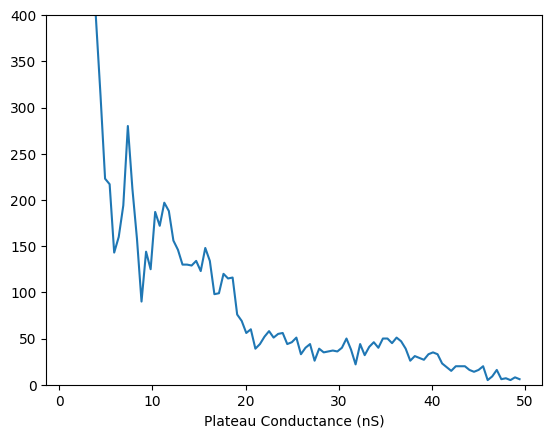

In [169]:
v,b=np.histogram(sigCond,bins=100)
plt.plot(b[1:],v)
plt.ylim([0,400])
plt.xlabel('Plateau Conductance (nS)')
plt.show()

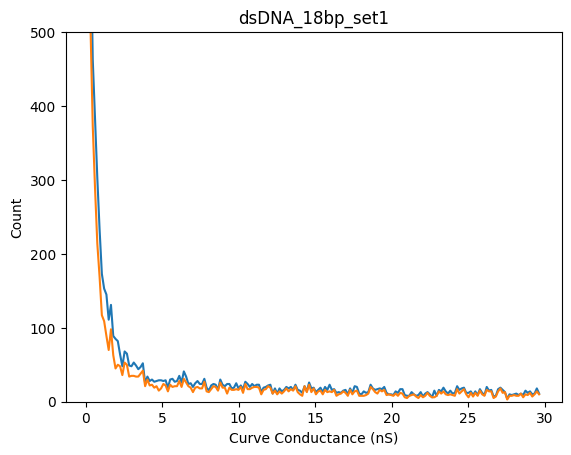

n Filtered
0.793559462122898
31457 24963


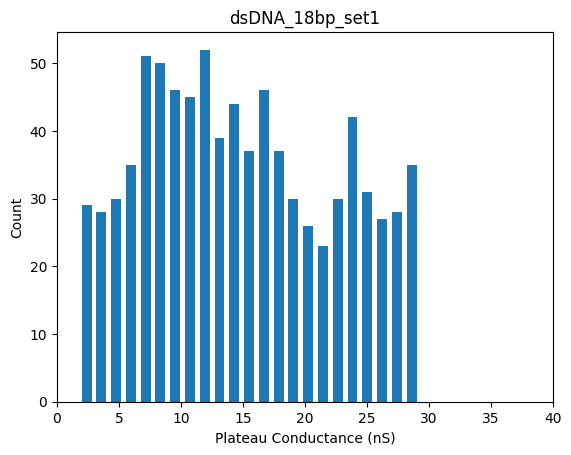

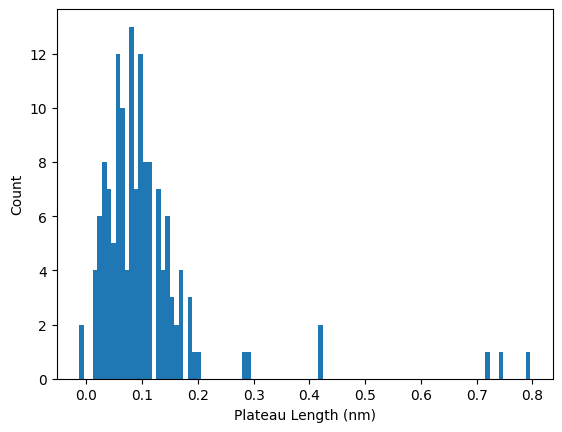

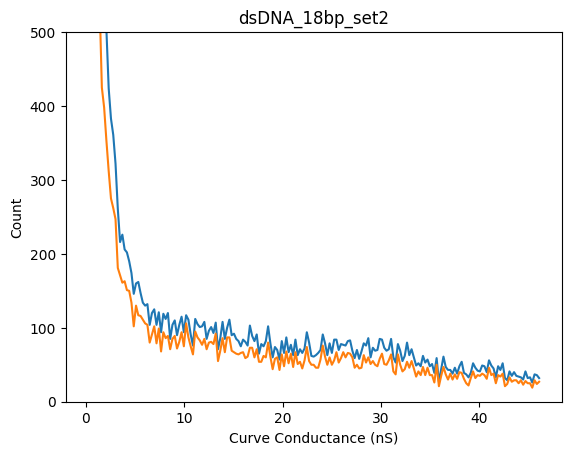

n Filtered
0.7056755114441969
123425 87098


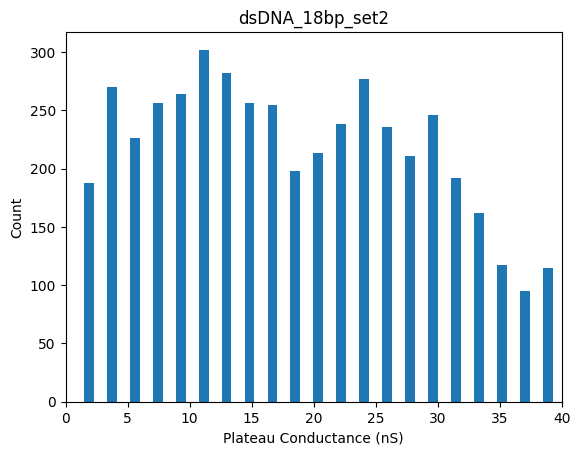

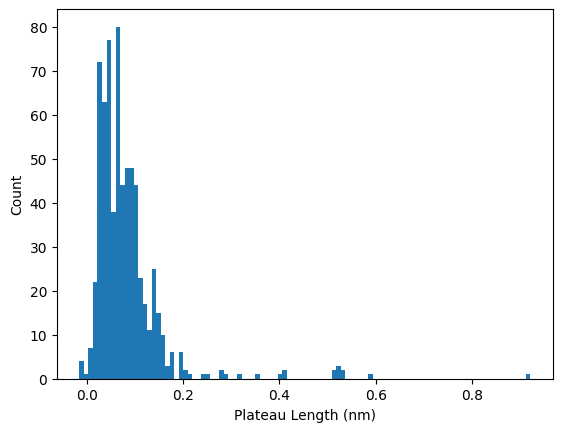

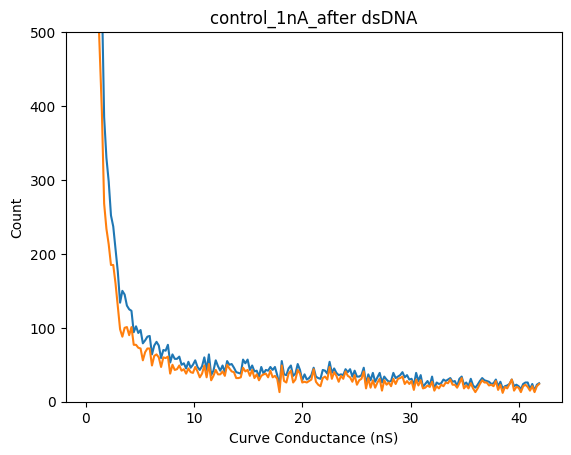

n Filtered
0.7673713778829095
67640 51905


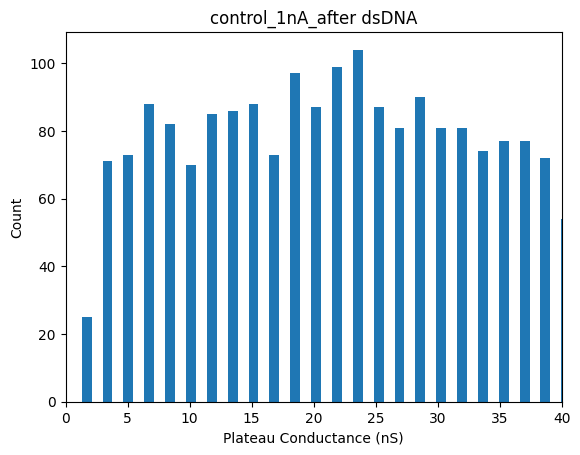

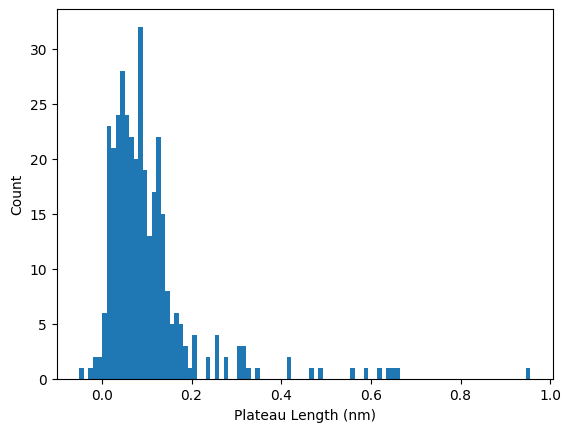

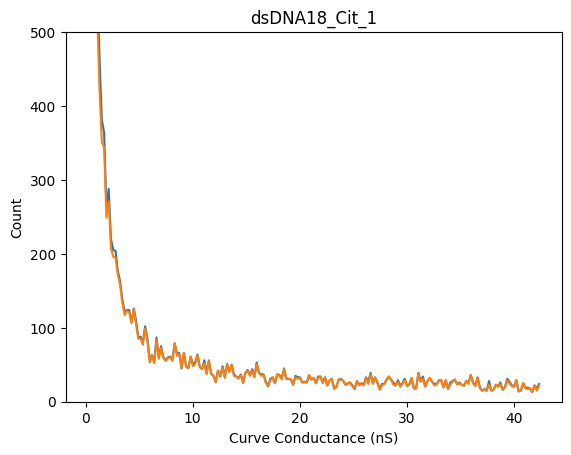

n Filtered
0.9188524279928845
52842 48554


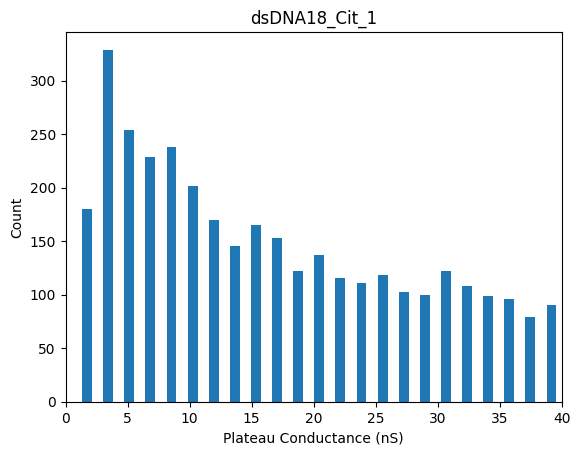

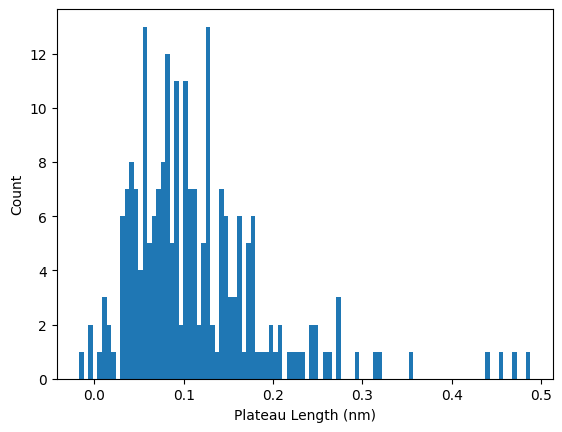

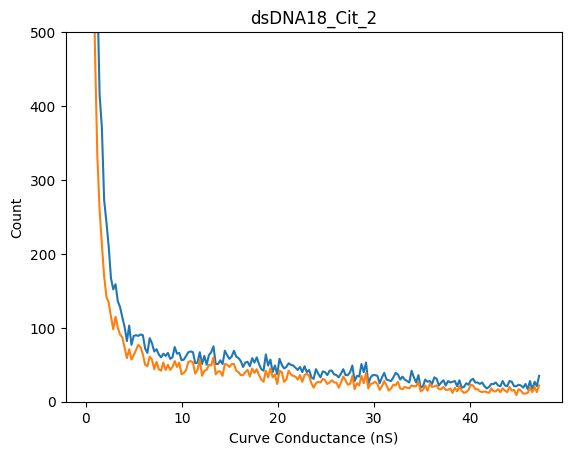

n Filtered
0.583205830806465
71894 41929


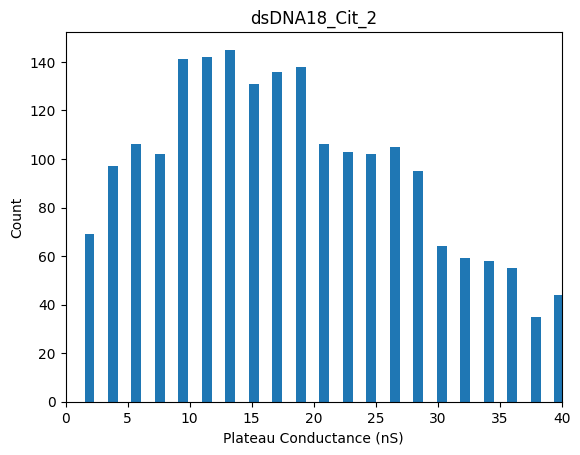

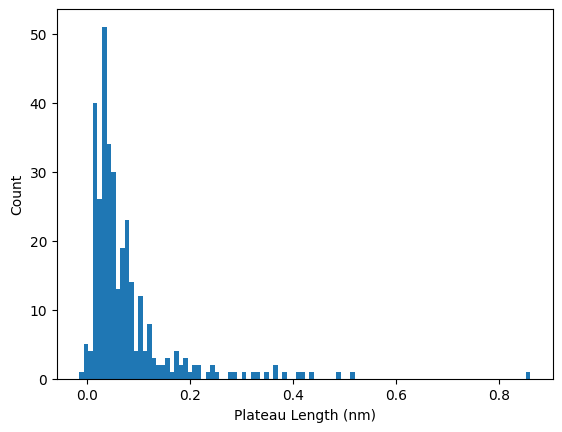

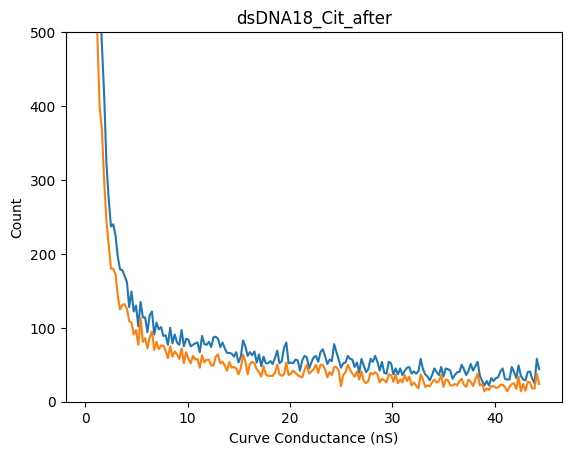

n Filtered
0.7296588635995026
73988 53986


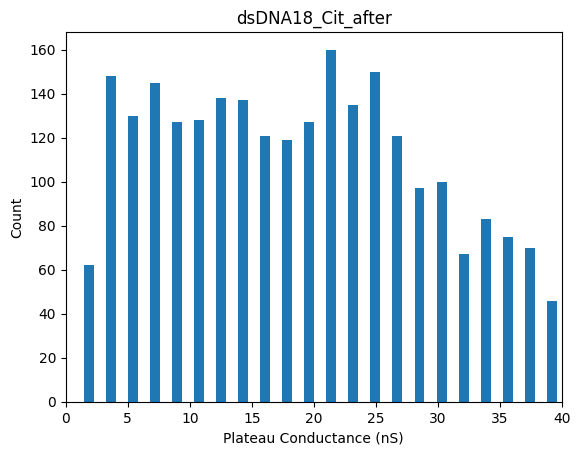

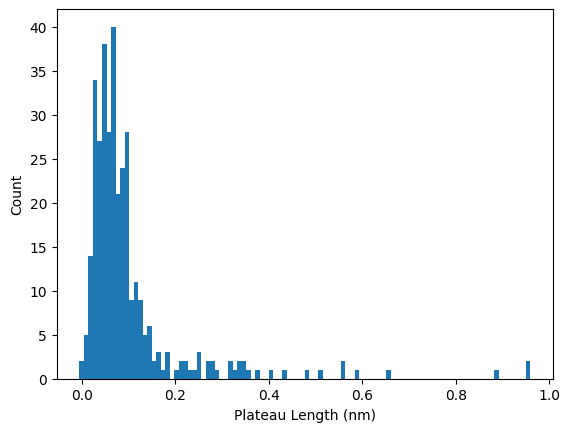

In [168]:
records={}
folders=[r"S:\Research\Sepideh Afsari\projects\STMBJ_dsDNA\dsDNA_18bp_set1",
    r"S:\Research\Sepideh Afsari\projects\STMBJ_dsDNA\dsDNA_18bp_set2",
          r"S:\Research\Sepideh Afsari\projects\STMBJ_dsDNA\control_1nA_after dsDNA",
          r"S:\Research\Sepideh Afsari\projects\STMBJ_dsDNA\20230131_STMBJ_dsDNA Cit\dsDNA18_Cit_1",
          r"S:\Research\Sepideh Afsari\projects\STMBJ_dsDNA\20230131_STMBJ_dsDNA Cit\dsDNA18_Cit_2",
          r"S:\Research\Sepideh Afsari\projects\STMBJ_dsDNA\20230131_STMBJ_dsDNA Cit\dsDNA18_Cit_after",
]
showLines=False
for sDir in folders:
    dataFiles = glob( sDir+ r"\*.mi", recursive=False)
    sName = os.path.basename(sDir)
    curves=[]
    for file in dataFiles:
        distance,currents,bias,times=loadMI(file)
        if len(distance)==1 and len(currents[0])>1 and np.max(np.abs(currents[0]))>9.9:
            d=distance[0]
            c=np.abs(currents[0]) 
            d2=d[c>9]
            bias=np.abs(bias)
            if len(d)>5 and len(d2)>5:
                d=d-np.max(d2)
                d2=d[(c<9) & (c>.025)]
                c2=c[(c<9) & (c>.025)]
                if len(d2)>0:
                    p=np.polyfit(d2,np.log(c2),1)
                    cc=np.mean(np.abs(c2-(np.exp(p[1]+p[0]*d2))))

                    if np.isfinite(cc)  :
                        jumps=np.argwhere( np.diff(c2)>0)
                        if len(jumps)>0:
                            plat=[ c2[jumps[0]],c2[jumps[-1]] ]
                        else:
                            plat=[]
                        deltaD=d2- np.interp(c2,  (np.exp(p[1]+p[0]*d2[::-1])), d2[::-1])
                        curves.append( {'current':c ,'bias':bias,'distance':d,'error':cc,'fit':p, 'plat':plat , 'delta':d2[deltaD>.02] })

    curves2=[x for x in curves if len(x['plat'])==2 and len(x['delta']>0)]
    curves2=sorted(curves2,key=lambda x: x['plat'][0])
    cc=0
    

    valuesC=[]
    valuesAll=[]
    valuesJumps=[]
    if showLines:
        plt.figure(figsize=(25,5))

    distances=[]    
    for curve in curves2:
        if curve['error']>.4 and np.max(curve['delta'])>.03  and np.max(curve['delta'])<1.5:
            d=curve['distance']
            c=curve['current']
            bias=curve['bias']

            d2=d[(c<9.5) & (d<1)]
            c2=c[(c<9.5) & (d<1)]
            diff=np.diff(c2,prepend=0)[:-5]
            jumps=np.argwhere( diff>0.05)-1

            jumps=jumps[ (jumps>1) & (c2[jumps]<9) & (c2[jumps]/bias>2.5)  ]

            if len(valuesC)==0:
                valuesAll,binAll=np.histogram(c2/bias ,bins=200)
            else:
                v,_=np.histogram(c2/bias ,bins=binAll)
                valuesAll+=v

            if len(jumps)>0  :
                distances.append( d2[jumps[-1]])
                ds=d2[jumps]
                v=(np.max(ds)-np.min(ds))
                #print( v , (v<.5) , (v>.01), end=' ')
                if   (v<.5) and (v>.01):

                    if showLines:
                        plt.plot(d2[d2>0]+cc*.15*1,c2[d2>0]/bias)
                        plt.scatter(d2[jumps]+cc*.15,c2[jumps]/bias)
                        plt.scatter(d2[jumps+1]+cc*.15,c2[jumps+1]/bias)


                    if len(valuesC)==0:
                        valuesC,bins=np.histogram(c2/bias ,bins=200)
                        v,binJ=np.histogram(c2 /bias  ,bins=25)
                        valuesJumps=np.zeros_like(v)
                    else:
                        v,_=np.histogram(c2/bias ,bins=bins)
                        valuesC+=v

                    valuesJumps+=np.histogram( c2[jumps]/bias ,bins=binJ)[0]
                    valuesJumps+=np.histogram( c2[jumps+1]/bias ,bins=binJ)[0]



                    cc+=1

                    if showLines and cc%30==0:
                        plt.title(sName)
                        plt.xlabel('Offset Distance (nm)')
                        plt.ylabel('Conductance (nS)')
                        plt.show()
                        plt.figure(figsize=(25,5))

    if showLines:
        plt.xlabel('Offset Distance (nm)')
        plt.ylabel('Conductance (nS)')
        plt.show()        

    b=bins[:-1]

    plt.plot(binAll[1:-1],valuesAll[1:])
    plt.plot(b[1:], valuesC[1:])
    plt.ylim([0,500])
    plt.title(sName)
    plt.ylabel('Count')
    plt.xlabel(r'Curve Conductance (nS)')
    plt.show()

    print('n Filtered')
    print(np.sum(valuesC)/np.sum(valuesAll))
    print(np.sum(valuesAll),np.sum(valuesC))
    plt.bar(binJ[1:-1], valuesJumps[1:])


    plt.title(sName)
    plt.xlim([0,40])
    plt.ylabel('Count')
    plt.xlabel(r'Plateau Conductance (nS)')
    plt.show()


    plt.hist(distances,bins=100)
    plt.ylabel('Count')
    plt.xlabel(r'Plateau Length (nm)')
    plt.show()

    records[sName]={'binJ':binJ,'valuesJumps':valuesJumps,'b':b,'valuesC':valuesC}

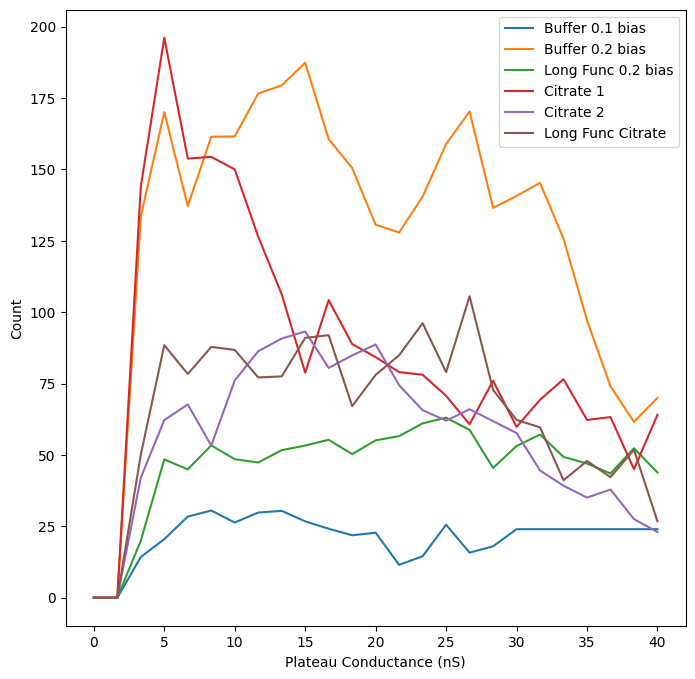

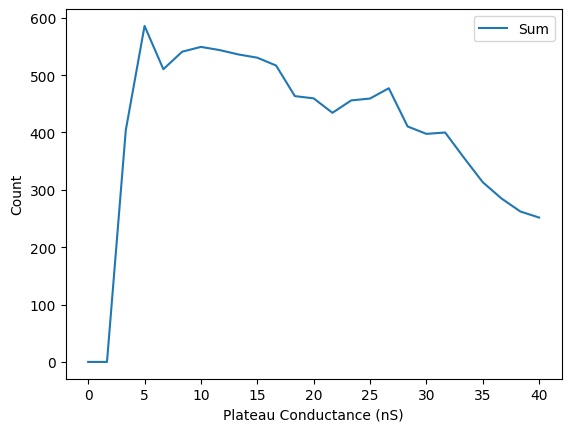

In [165]:
plt.figure(figsize=(8,8))
bins=np.linspace(0,40,25)
sums=np.zeros_like(bins)
for r in records:
    item = records[r]
    b=item['binJ'][1:]
    v=item['valuesJumps']
     
    vp=np.interp(bins,b,v)
    sums+=vp
    if 'Cit_1' in r:
        r='Citrate 1 '
    if 'Cit_2' in r:
        r='Citrate 2'
    if 'set1' in r:
        r='Buffer 0.1 bias'
    if 'set2' in r:
        r='Buffer 0.2 bias'
    if 'after dsDNA' in r:
        r='Long Func 0.2 bias'
    if 'Cit_after' in r:
        r='Long Func Citrate'        
    plt.plot(bins,vp ,label=r)

plt.ylabel('Count')
plt.xlabel(r'Plateau Conductance (nS)')
plt.legend()
plt.show()


plt.plot(bins,sums ,label='Sum')

plt.ylabel('Count')
plt.xlabel(r'Plateau Conductance (nS)')
plt.legend()
plt.show()

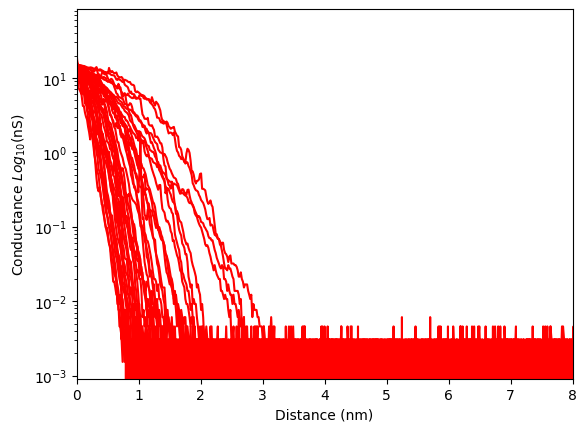

In [10]:
dataFiles = glob( r"S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\STM\20230111_firstcontrol_then_sDNA_DNAinsolution\DriftJunction_DNA\\*.mi", recursive=False)
glob( r"S:\Research\Sepideh Afsari\projects\STMBJ_dsDNA\dsDNA_18bp\\*.mi", recursive=False) 
bins=np.linspace(np.log10(1e-5/.2),np.log10(10/.2),50)
distThresh=0
valuesC=[]
for file in dataFiles:
    distance,currents=loadMI(file)
    if len(distance)==2  :
        d=distance[1]
        if len(d)>0:
            c=np.abs(currents[1]) 
            d2=d[c>3]
            if len(d2)>0:
                d=d-np.max(d2)
                plt.semilogy(d ,c/.2,c='r')          
    else:
        d=distance[0]
        if len(d)>0:
            c=np.abs(currents[0]) 
            d2=d[c>3]
            if len(d2)>0:
                d=d-np.max(d2)
                plt.semilogy(d ,c/.2,c='r')      
        
  
        
            
plt.xlim([0,8]) 
plt.ylabel(r'Conductance $Log_{10}$(nS)')
plt.xlabel('Distance (nm)')
plt.show()

C:\Users\bashc\AppData\Local\Temp\ipykernel_23792\3152853779.py:11: RuntimeWarning: divide by zero encountered in log10
  c2=np.log10(c/.2)
C:\Users\bashc\AppData\Local\Temp\ipykernel_23792\3152853779.py:34: RuntimeWarning: divide by zero encountered in log10
  c2=np.log10(c/.2)


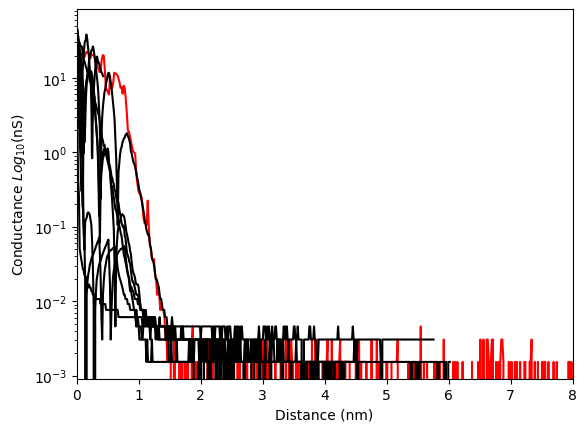

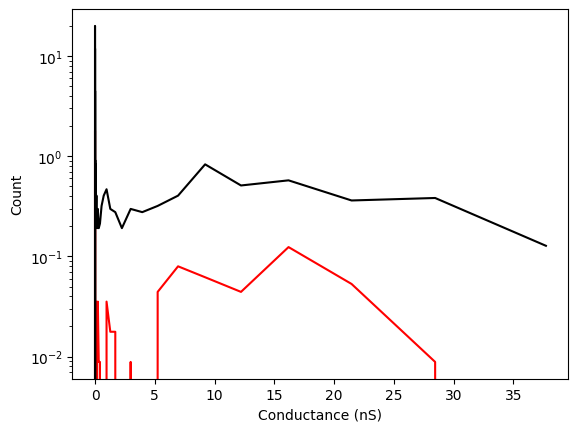

In [45]:
dataFiles = glob( r"S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\STM\20230111_firstcontrol_then_sDNA_DNAinsolution\DriftJunction_DNA\\*.mi", recursive=False)
 
bins=np.linspace(np.log10(1e-5/.2),np.log10(10/.2),50)
distThresh=0
valuesC=[]
for file in dataFiles:
    distance,currents=loadMI(file)
    if len(distance)==2  :
        d=distance[1]
        c=np.abs(currents[1]) 
        c2=np.log10(c/.2)
        d2=d[c>9]
        if len(d)>5 and len(d2)>5:
            d=d-np.max(d2)
            if len(valuesC)==0:
                valuesC,_=np.histogram(c2[d>distThresh],bins=bins)
            else:
                v,_=np.histogram(c2[d>distThresh],bins=bins)
                valuesC+=v
            plt.semilogy(d ,c/.2,c='r')        
        
normV=len(dataFiles)            
values=valuesC
        
dataFiles = []
dataFiles.extend(glob( r"S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\STM\20230111_firstcontrol_then_sDNA_DNAinsolution\DriftJunction_control\\*.mi", recursive=False))
valuesC=[] 
for file in dataFiles:
    distance,currents=loadMI(file)
    
    if len(distance)==2  :
        d=distance[1]
        c=np.abs(currents[1]) 
        c2=np.log10(c/.2)
        d2=d[c>9]
        if len(d)>5 and len(d2)>5:
            d=d-np.max(d2)
            if len(valuesC)==0:
                valuesC,_=np.histogram(c2[d>distThresh],bins=bins)
            else:
                v,_=np.histogram(c2[d>distThresh],bins=bins)
                valuesC+=v
            plt.semilogy(d ,c/.2,c='k')  

            
            
normC=len(dataFiles)

 
            
plt.xlim([0,8]) 
plt.ylabel(r'Conductance $Log_{10}$(nS)')
plt.xlabel('Distance (nm)')
plt.show()

plt.semilogy(10**bins[:-1], values/normV,c='r')
plt.semilogy(10**bins[:-1],valuesC/normC,c='k')
 
plt.ylabel('Count')
plt.xlabel(r'Conductance (nS)')
plt.show()

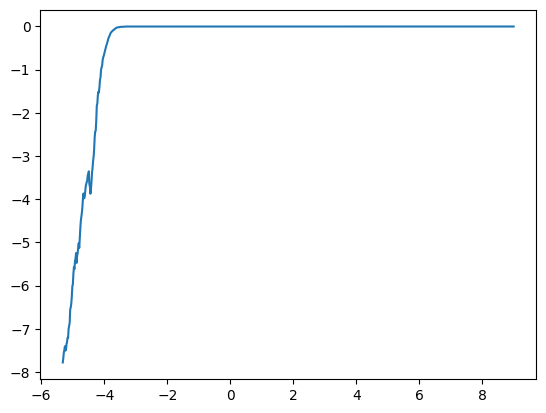

In [47]:
plt.plot(distance[1],currents[1])

In [79]:
dataFiles = glob( r"S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\STM\DNA\20230106_dsDNA_DNABuffer_100nMdsDNApurified\Breakjunction\\*.mi", recursive=False)
bins=np.linspace(0,10,100)
values=[]
for file in dataFiles:
    distance,currents=loadMI(file)
    if len(distance)>1:
        d=distance[1]
        c=np.abs(currents[1])
        if len(values)==0:
            values,_=np.histogram(c,bins=bins)
        else:
            v,_=np.histogram(c,bins=bins)
            values+=v

values2=[]
dataFiles = glob( r"S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\STM\DNA\20230105_dsDNA_50uMTCEP_1nMdsDNA_MilliQ\Breakjunction\\*.mi", recursive=False)
for file in dataFiles:
    distance,currents=loadMI(file)
    if len(distance)>1:
        d=distance[1]
        c=np.abs(currents[1])
        if len(values2)==0:
            values2,_=np.histogram(c,bins=bins)
        else:
            v,_=np.histogram(c,bins=bins)
            values2+=v
        
 

C:\Users\bashc\AppData\Local\Temp\ipykernel_37564\3308877412.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(bins[1:],np.log(values),label='Purified dsDNA')
C:\Users\bashc\AppData\Local\Temp\ipykernel_37564\3308877412.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(bins[1:],np.log(values2),label='mercapto & dsDNA')


ValueError: x and y must have same first dimension, but have shapes (299,) and (99,)

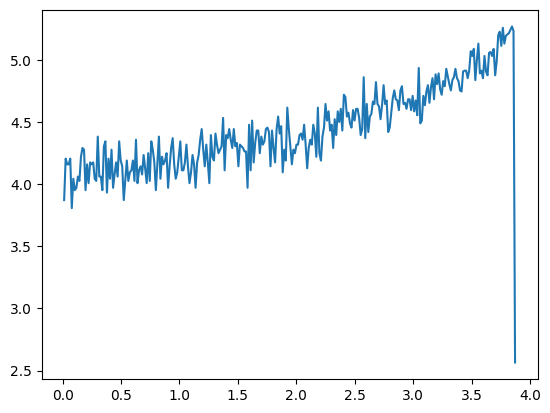

In [111]:
plt.plot(bins[1:],np.log(values),label='Purified dsDNA')
plt.plot(bins[1:],np.log(values2),label='mercapto & dsDNA')
plt.legend()


In [112]:
dataFiles = glob( r"S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\STM\DNA\20230106_dsDNA_DNABuffer_100nMdsDNApurified\Breakjunction\\*.mi", recursive=False)
len(dataFiles)

505

In [78]:
bins

array([ 0.        ,  0.99993896,  1.99987793,  2.99981689,  3.99975586,
        4.99969482,  5.99963379,  6.99957275,  7.99951172,  8.99945068,
        9.99938965, 10.99932861, 11.99926758, 12.99920654, 13.99914551,
       14.99908447, 15.99902344, 16.9989624 , 17.99890137, 18.99884033,
       19.9987793 , 20.99871826, 21.99865723, 22.99859619, 23.99853516,
       24.99847412, 25.99841309, 26.99835205, 27.99829102, 28.99822998,
       29.99816895, 30.99810791, 31.99804688, 32.99798584, 33.9979248 ,
       34.99786377, 35.99780273, 36.9977417 , 37.99768066, 38.99761963,
       39.99755859, 40.99749756, 41.99743652, 42.99737549, 43.99731445,
       44.99725342, 45.99719238, 46.99713135, 47.99707031, 48.99700928,
       49.99694824, 50.99688721, 51.99682617, 52.99676514, 53.9967041 ,
       54.99664307, 55.99658203, 56.996521  , 57.99645996, 58.99639893,
       59.99633789, 60.99627686, 61.99621582, 62.99615479, 63.99609375,
       64.99603271, 65.99597168, 66.99591064, 67.99584961, 68.99

In [8]:
file=r'S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\STM\2023_test\3756997716_0_test.tdms'
t0=0
tdms_file = TdmsFile.read(file)
for group in tdms_file.groups():
    group_name = group.name
    bias=[]
    for channel in group.channels():
        channel_name = channel.name
        if (channel_name=="Time"):
            timeC1=np.array(channel)-t0
        elif channel_name=="Bias":
            bias=np.array(channel)
        else:    
            currentIV=np.array(channel)

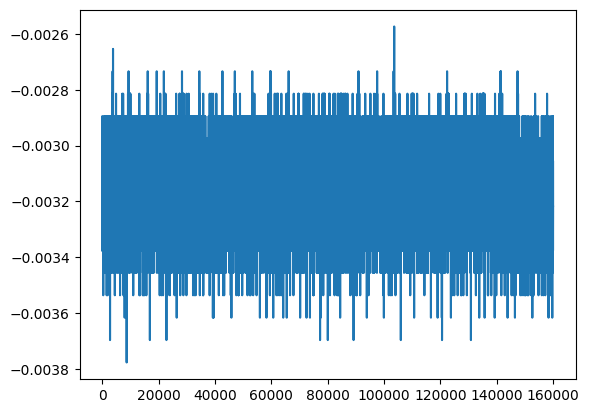

In [9]:
plt.plot(currentIV[10:])